## Minimum code for plotting Hel2-del and Syh1-del codon pair library effects
- (Figure 4)

In [2]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(plotrix))

AMINO_ACID_CODE["*"] = "*"

barcode_reads_cutoff <- 10 # each individual barcode should have >= these many reads
n_barcodes_cutoff <- 2 # each insert should have >= this many barcodes

### Global plotting themes

In [3]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [4]:
if (!file.exists('../figures')){
    dir.create('../figures')}
if (!file.exists('../tables')){
    dir.create('../tables')}

## Load and combine barcode counts

In [5]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert)

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 99948 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 163535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 110997 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the colu

In [7]:
barcode_counts <- counts %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    mutate(sample_type = ifelse(str_detect(sample_type, 'reseq'), str_extract(sample_name, '(?<=_).+(?=_)'), sample_type)) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count) %>%
    group_by(genotype, sample_type, barcode_num, insert_num) %>% # combine resequenced counts together
    summarize(barcode_count = sum(barcode_count), .groups='drop')

In [8]:
barcode_counts %>%
    write_tsv("../tables/barcode_insert_counts.tsv.gz")

In [9]:
wt_barcode_counts <- read_tsv("../../wt_mrna_grna/tables/barcode_insert_counts.tsv.gz") %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count)

Rows: 370377 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): barcode, sample_name, linkage_ref
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Prepare data for bootstrapping: apply minimal filters and separate by strain

In [10]:
hel2_dicodons <- barcode_counts %>%
    filter(genotype == 'hel2') %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(sample_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>% # filter out inserts that don't reach barcode rep cutoff while maintaining data as individual barcodes
    ungroup() %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(n_barcodes, barcode_count)) %>%
    drop_na()

In [11]:
syh1_dicodons <- barcode_counts %>%
    filter(genotype == 'syh1') %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(sample_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>%
    ungroup() %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(n_barcodes, barcode_count)) %>%
    drop_na()

In [12]:
wt_dicodons <- wt_barcode_counts %>%
    filter(genotype == 'wt') %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(sample_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>%
    ungroup() %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(n_barcodes, barcode_count)) %>%
    drop_na()

In [13]:
dicodons_with_barcode_cutoffs <- bind_rows(hel2_dicodons, syh1_dicodons, wt_dicodons) %>%
  left_join(insert_annotations, by=c('insert_num', 'dicodon', 'diaa'))

### Bootstrap by dipeptide

In [14]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$barcode_count_mrna)) - log2(sum(d$barcode_count_gdna))
}

wt_boot_diaa <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'wt') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='WT')

hel2_boot_diaa <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'hel2') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Hel2-del')

syh1_boot_diaa <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'syh1') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Syh1-del')

bootstrap_diaa <- bind_rows(wt_boot_diaa, hel2_boot_diaa, syh1_boot_diaa)

In [15]:
dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'wt') %>%
  group_by(diaa) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-diaa, -n_barc)

dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'hel2') %>%
  group_by(diaa) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-diaa, -n_barc)

dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'syh1') %>%
  group_by(diaa) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-diaa, -n_barc)

avg,med
<dbl>,<dbl>
202.1914,141.5


avg,med
<dbl>,<dbl>
127,84.5


avg,med
<dbl>,<dbl>
147.4402,99


### Correlate between strains

In [16]:
sd_outliers <- bootstrap_diaa %>%
    group_by(genotype) %>%
    mutate(iqr = IQR(lfc_sd)) %>%
    mutate(q3 = quantile(lfc_sd, c(0.75))) %>%
    slice(1) %>%
    mutate(outlier = q3 + (iqr*1.5)) %>%
    select(genotype, iqr, outlier)

In [17]:
hel2_out_sd <- sd_outliers$outlier[[1]] + 0.05 # relax the sd filter a bit
syh1_out_sd <- sd_outliers$outlier[[2]] + 0.05
wt_out_sd <- sd_outliers$outlier[[3]] + 0.05

In [18]:
avg_data <- bootstrap_diaa %>%
    pivot_wider(names_from=genotype, values_from=c(lfc, lfc_med, lfc_sd))

res <- lm(avg_data$lfc_med_WT ~ avg_data$`lfc_med_Hel2-del`)

idx <- rstandard(res) %>%
    enframe() %>%
    filter(value <= -2) %>%
    dplyr::pull(as.numeric(name))

residuals <- rstandard(res) %>%
    enframe() %>%
    dplyr::rename('x1'='name') %>%
    mutate(x1 = as.numeric(x1))

plot_data <- avg_data %>%
    mutate(x1 = seq(1,dplyr::n(),1)) %>%
    left_join(residuals, by='x1') %>%
    mutate(label = ifelse((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Hel2-del` <= hel2_out_sd) & (x1 %in% idx), 'high_residual', 'as_predicted')) %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Hel2-del` <= hel2_out_sd))
    # mutate(label = ifelse(x1 %in% idx, 'high_residual', 'as_predicted'))

label_df <- plot_data %>%
    filter(label=='high_residual') %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Hel2-del` <= hel2_out_sd))

In [19]:
plot_data %>%
    group_by(diaa) %>%
    summarize(n()) %>%
    nrow()

[1] 367

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


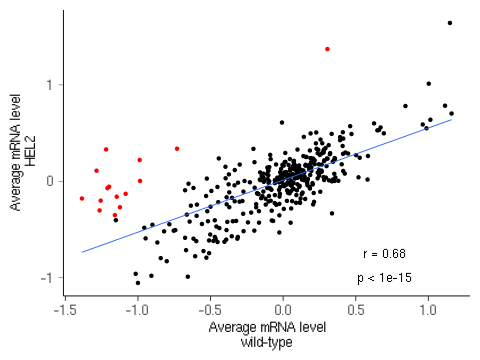

In [20]:
r = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Hel2-del`, method='pearson')$estimate
p = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Hel2-del`, method='pearson')$p.value

plot_data  %>%
    ggplot(aes(x=lfc_med_WT, y=`lfc_med_Hel2-del`)) +
    geom_point(size=0.2, aes(color=label)) +
    geom_smooth(method=lm, se=FALSE, size=0.2) +
    annotate('text', x=0.7, y=-0.75, label=str_c('r = ', round(r,2)), size=7/.pt) +
    annotate('text', x=0.7, y=-1.0, label='p < 1e-15', size=7/.pt) +
    # geom_text_repel(data=label_df, mapping=aes(x=lfc_med_WT, y=`lfc_med_Hel2-del`, label=diaa), max.overlaps=50, size=3/.pt, segment.size=0.1) +
    theme +
    theme(axis.ticks.y=element_line(size=0.1),
        ) +
    scale_color_manual(values=c('as_predicted'='black', 'high_residual'='red')) +
    guides(color='none') +
    labs(x='Average mRNA level\nwild-type', y='Average mRNA level\n hel2')

ggsave("../figures/fig4_wt_hel2_diaa_corr.pdf", width=1.9, height=1.7, units='in', dpi=300)

In [21]:
res <- lm(avg_data$lfc_med_WT ~ avg_data$`lfc_med_Syh1-del`)

idx <- rstandard(res) %>%
    enframe() %>%
    filter(value <= -2) %>%
    dplyr::pull(as.numeric(name))

residuals <- rstandard(res) %>%
    enframe() %>%
    dplyr::rename('x1'='name') %>%
    mutate(x1 = as.numeric(x1))

plot_data <- avg_data %>%
    mutate(x1 = seq(1,dplyr::n(),1)) %>%
    left_join(residuals, by='x1') %>%
    mutate(label = ifelse((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Syh1-del` <= syh1_out_sd) & (x1 %in% idx), 'high_residual', 'as_predicted')) %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Syh1-del` <= syh1_out_sd))

label_df <- plot_data %>%
    filter(label=='high_residual') %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Syh1-del` <= syh1_out_sd))

In [22]:
plot_data %>%
    group_by(diaa) %>%
    summarize(n()) %>%
    nrow()

[1] 367

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


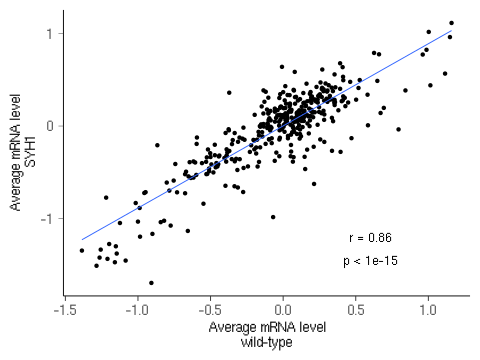

In [23]:
r = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Syh1-del`, method='pearson')$estimate
p = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Syh1-del`, method='pearson')$p.value

plot_data  %>%
    ggplot(aes(x=lfc_med_WT, y=`lfc_med_Syh1-del`)) +
    geom_point(size=0.2, aes(color=label)) +
    geom_smooth(method=lm, se=FALSE, size=0.2) +
    annotate('text', x=0.6, y=-1.20, label=str_c('r = ', round(r, 2)), size=7/.pt) +
    annotate('text', x=0.6, y=-1.45, label='p < 1e-15', size=7/.pt) +
    theme +
    theme(axis.ticks.y=element_line(size=0.1),
        ) +
    scale_color_manual(values=c('as_predicted'='black', 'high_residual'='red')) +
    # geom_text(data = label_df, aes(x=lfc_med_WT, y=`lfc_med_Syh1-del`, label=diaa), color='black', size=5/.pt) + 
    guides(color='none') +
    labs(x='Average mRNA level\nwild-type', y='Average mRNA level\n syh1')

ggsave("../figures/fig4_wt_syh1_diaa_corr.pdf", width=1.9, height=1.7, units='in', dpi=300)

### Pull out the dipeptides with the greatest bootstrapped delta where WT is destabilized

In [24]:
destab_wt <- read_csv("../../wt_mrna_grna/tables/destabilized_wt.csv") %>%
    filter(Frame == "In-frame") %>%
    dplyr::pull(match_diaa)

Rows: 40 Columns: 6


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Frame, match_diaa
dbl (4): lfc, lfc_sd, var, lfc_med

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


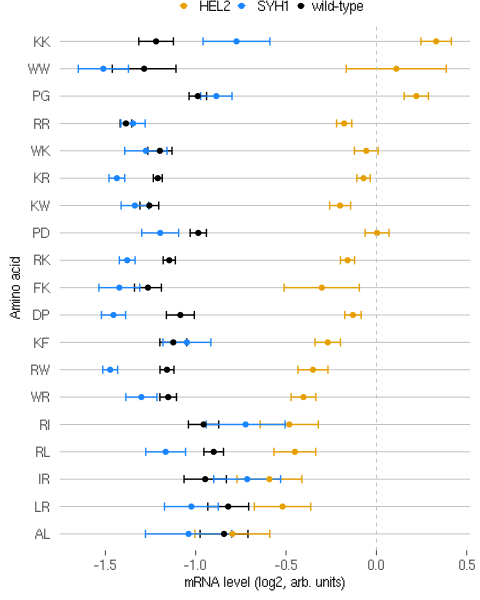

In [28]:
options(repr.plot.width = 4, repr.plot.height = 5)

bootstrap_diaa %>%
  filter(diaa %in% c(destab_wt)) %>%
  filter(!str_detect(diaa, '\\*')) %>%
  filter(diaa != 'YK') %>%
  group_by(diaa) %>%
  mutate(order = lfc_med[genotype == 'Hel2-del'] - lfc_med[genotype == 'WT']) %>%
  mutate(genotype = case_when(genotype == 'WT' ~ 'wild-type', genotype == 'Hel2-del' ~ ' hel2', genotype == 'Syh1-del' ~ ' syh1')) %>%
  ungroup() %>%
  mutate(diaa = fct_reorder(diaa, order)) %>%
  ggplot(aes(x = lfc_med, y = diaa,
             xmin = lfc_med - lfc_sd, xmax = lfc_med + lfc_sd,
             color=genotype)) +
  geom_errorbar(width=0.3, size=0.3) +
  geom_point(size=0.7) +
  scale_color_manual(values=c('wild-type'='black', ' hel2'='#E69F00', ' syh1' = '#1A85FF')) +
  # scale_x_continuous(breaks=seq(-2.5,1,0.5), limits=c(-2.5,0.5)) +
  theme + 
  theme(legend.position = "top",
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        ) +
  labs(x = "mRNA level (log2, arb. units)", y = "Amino acid", color='') +
  geom_vline(xintercept=0, color='grey', size=0.2, linetype=2)

ggsave("../figures/fig4_destab_diaa_in_wt.pdf", width=2.4, height=3.15)

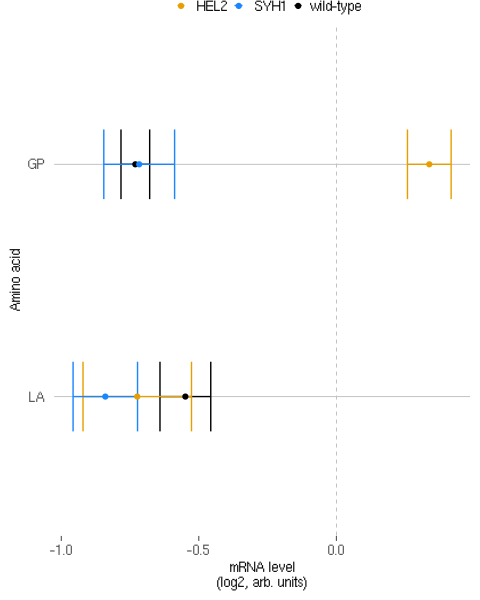

In [27]:
options(repr.plot.width = 4, repr.plot.height = 5)

bootstrap_diaa %>%
  filter(diaa %in% c('GP', 'LA')) %>%
  filter(!str_detect(diaa, '\\*')) %>%
  group_by(diaa) %>%
  mutate(order = lfc_med[genotype == 'Hel2-del'] - lfc_med[genotype == 'WT']) %>%
  mutate(genotype = case_when(genotype == 'WT' ~ 'wild-type', genotype == 'Hel2-del' ~ ' hel2', genotype == 'Syh1-del' ~ ' syh1')) %>%
  ungroup() %>%
  mutate(diaa = fct_reorder(diaa, order)) %>%
  ggplot(aes(x = lfc_med, y = diaa,
             xmin = lfc_med - lfc_sd, xmax = lfc_med + lfc_sd,
             color=genotype)) +
  geom_errorbar(width=0.3, size=0.3) +
  geom_point(size=0.7) +
  scale_color_manual(values=c('wild-type'='black', ' hel2'='#E69F00', ' syh1' = '#1A85FF')) +
  theme + 
  theme(legend.position = "top",
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        ) +
  labs(x = "mRNA level\n(log2, arb. units)", y = "Amino acid", color='') +
  geom_vline(xintercept=0, color='grey', size=0.2, linetype=2)

ggsave("../figures/sfig_destab_diaa_in_wt_gp.pdf",width=1.9, height=1.35)

## Look at codon level effects

In [33]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$barcode_count_mrna)) - log2(sum(d$barcode_count_gdna))
}

wt_boot_dicodon <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'wt') %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='WT')

hel2_boot_dicodon <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'hel2') %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Hel2-del')

syh1_boot_dicodon <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'syh1') %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Syh1-del')

bootstrap_dicodon <- bind_rows(wt_boot_dicodon, hel2_boot_dicodon, syh1_boot_dicodon)

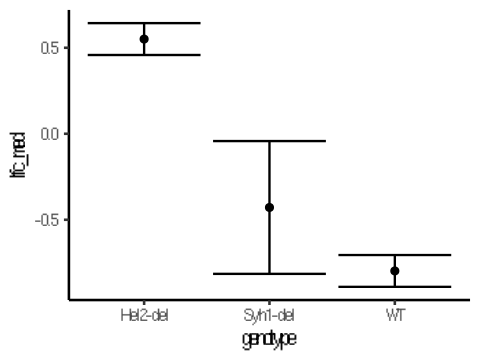

In [55]:
options(repr.plot.width = 4, repr.plot.height = 3)

bootstrap_dicodon %>%
    filter(dicodon == 'CGACGA') %>%
    ggplot() +
    aes(x=genotype, y=lfc_med, ymin=lfc_med-lfc_sd, ymax=lfc_med+lfc_sd) +
    geom_point() +
    geom_errorbar()